In [13]:
import sqlite3
import pandas as pd
import numpy as np
import io
import brainaccess_board as bb
import matplotlib.pyplot as plt

db_path = r"C:\Users\henri\Documents\BrainAccessData\sub-001\ses-001\subj-1_ses-S001_task-task4_run-001_20250829_141441_eeg.db"

Check data exists

In [14]:
from brainaccess_board.database import ReadDB
db = ReadDB(filename=db_path)  # or "current" for the active one
print("DB path:", db.name)
# Get all devices as {device_id: mne.io.Raw}
raw_dict = db.get_mne()                     # returns a dict of MNE Raw objects
print(list(raw_dict.keys()))
raw = next(iter(raw_dict.values()))         # pick first Raw if you only have one

# Markers (your annotations) are already attached here:
ann = raw.annotations
print("N annotations:", len(ann))
print("onsets (s):", ann.onset)
print("labels:", ann.description)

DB path: C:\Users\henri\Documents\BrainAccessData\sub-001\ses-001\subj-1_ses-S001_task-task4_run-001_20250829_141441_eeg.db
['77a71df6-9729-4d38-a3c0-536539258aff']
N annotations: 12
onsets (s): [35.983404 50.986203 51.669497 61.672109 62.088595 72.090958 72.52507
 82.527218 82.94439  92.946568 93.330365 94.864114]
labels: ['201' '101' '201' '101' '201' '101' '201' '101' '201' '101' '201' '']


In [15]:
# Annotations → DataFrame
ann_df = pd.DataFrame({
    "onset_s": ann.onset,
    "duration_s": ann.duration,
    "label": ann.description
})

# EEG samples → DataFrame (channels are columns; time in seconds)
data = raw.get_data()    # shape (n_channels, n_times)
times = raw.times        # length n_times
eeg_df = pd.DataFrame(data.T, columns=raw.ch_names)
eeg_df.insert(0, "t_s", times)
eeg_df

,t_s,P8,O2,P4,C4,F8,F4,Oz,Cz,Fz,...,T7,CP1,CP5,PO3,Accel_x,Accel_y,Accel_z,Sample,Streaming,Battery
0,0.000,0.262388,0.262510,0.262514,0.262643,0.262736,0.262567,0.262390,0.262212,0.262636,...,0.263007,0.262922,0.263025,0.263043,9.446746,-0.344213,-0.420705,1018083.0,1.0,35.0
1,0.004,0.262247,0.262370,0.262374,0.262503,0.262596,0.262427,0.262250,0.262072,0.262496,...,0.262866,0.262782,0.262885,0.262902,9.446746,-0.344213,-0.420705,1018084.0,1.0,35.0
2,0.008,0.262192,0.262315,0.262319,0.262448,0.262541,0.262372,0.262195,0.262016,0.262441,...,0.262811,0.262726,0.262829,0.262847,9.446746,-0.344213,-0.420705,1018085.0,1.0,35.0
3,0.012,0.262292,0.262414,0.262419,0.262547,0.262641,0.262471,0.262296,0.262116,0.262541,...,0.262910,0.262826,0.262929,0.262947,9.446746,-0.344213,-0.420705,1018086.0,1.0,35.0
4,0.016,0.262413,0.262536,0.262540,0.262669,0.262762,0.262593,0.262416,0.262237,0.262662,...,0.263032,0.262948,0.263050,0.263069,9.446746,-0.344213,-0.420705,1018087.0,1.0,35.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24697,98.788,0.264488,0.264610,0.264615,0.264745,0.264837,0.264667,0.264489,0.264310,0.264733,...,0.265108,0.265023,0.265126,0.265144,9.446746,0.000000,1.644575,1042780.0,1.0,34.0
24698,98.792,0.264636,0.264758,0.264764,0.264893,0.264986,0.264815,0.264638,0.264458,0.264882,...,0.265256,0.265171,0.265274,0.265292,9.446746,0.000000,1.644575,1042781.0,1.0,34.0
24699,98.796,0.264791,0.264912,0.264918,0.265048,0.265140,0.264969,0.264792,0.264612,0.265035,...,0.265411,0.265326,0.265429,0.265447,9.446746,0.000000,1.644575,1042782.0,1.0,34.0
24700,98.800,0.264738,0.264859,0.264865,0.264994,0.265087,0.264916,0.264738,0.264559,0.264982,...,0.265357,0.265273,0.265376,0.265393,9.446746,0.000000,1.644575,1042783.0,1.0,34.0


Plot signals before filtering

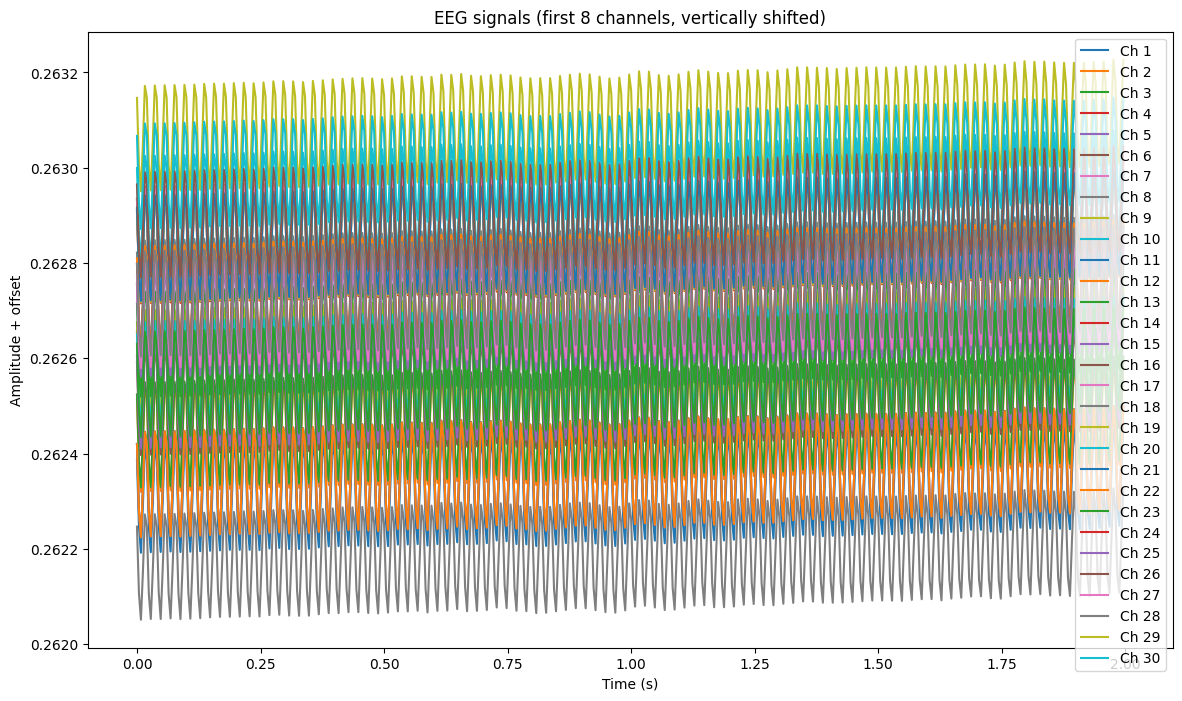

In [20]:
plt.figure(figsize=(14, 8))

fs = 250  # Hz (check your board config)
duration =  2 # seconds
n_samples = fs * duration
offset = 0.000005  # vertical offset so signals don’t overlap
for ch in range(30):   # plot first 20 channels
    j=eeg_df.columns[ch+1]
    plt.plot(
        eeg_df['t_s'][:n_samples],
        eeg_df[j][:n_samples] + ch * offset,
        label=f"Ch {ch+1}"
    )

plt.title("EEG signals (first 8 channels, vertically shifted)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude + offset")
plt.legend()
plt.show()

Filter and plot

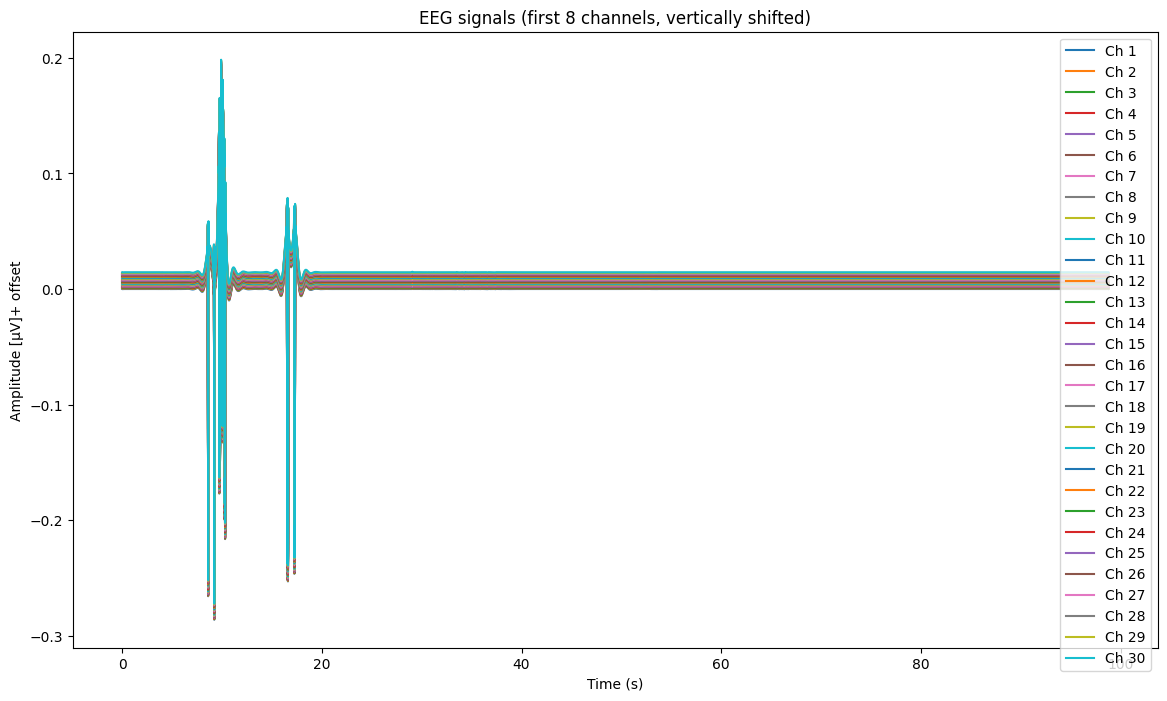

In [22]:
from scipy.signal import butter, sosfiltfilt, filtfilt


def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y



for ch in eeg_df.columns[1:31]:   
    eeg_df[ch] = butter_bandpass_filter(eeg_df[ch].values, 1, 40, fs)

signals2 = eeg_df

    # Normalize EEG data
eps = 1e-20  # To avoid division by zero in this example
#signals2 = (signals2 - np.mean(signals2, axis=0)) / (np.std(signals2, axis=0) + eps)

plt.figure(figsize=(14, 8))

fs = 250  # Hz (check your board config)
duration =  180 # seconds
n_samples = fs * duration
offset = 0.0005  # vertical offset so signals don’t overlap
for ch in range(30):   # plot first 20 channels
    j=signals2.columns[ch+1]
    plt.plot(
        signals2['t_s'][:n_samples],
        signals2[j][:n_samples] + ch * offset,
        label=f"Ch {ch+1}"
    )

plt.title("EEG signals (first 8 channels, vertically shifted)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude [µV]+ offset")
plt.legend()
plt.show()

Band decomposition

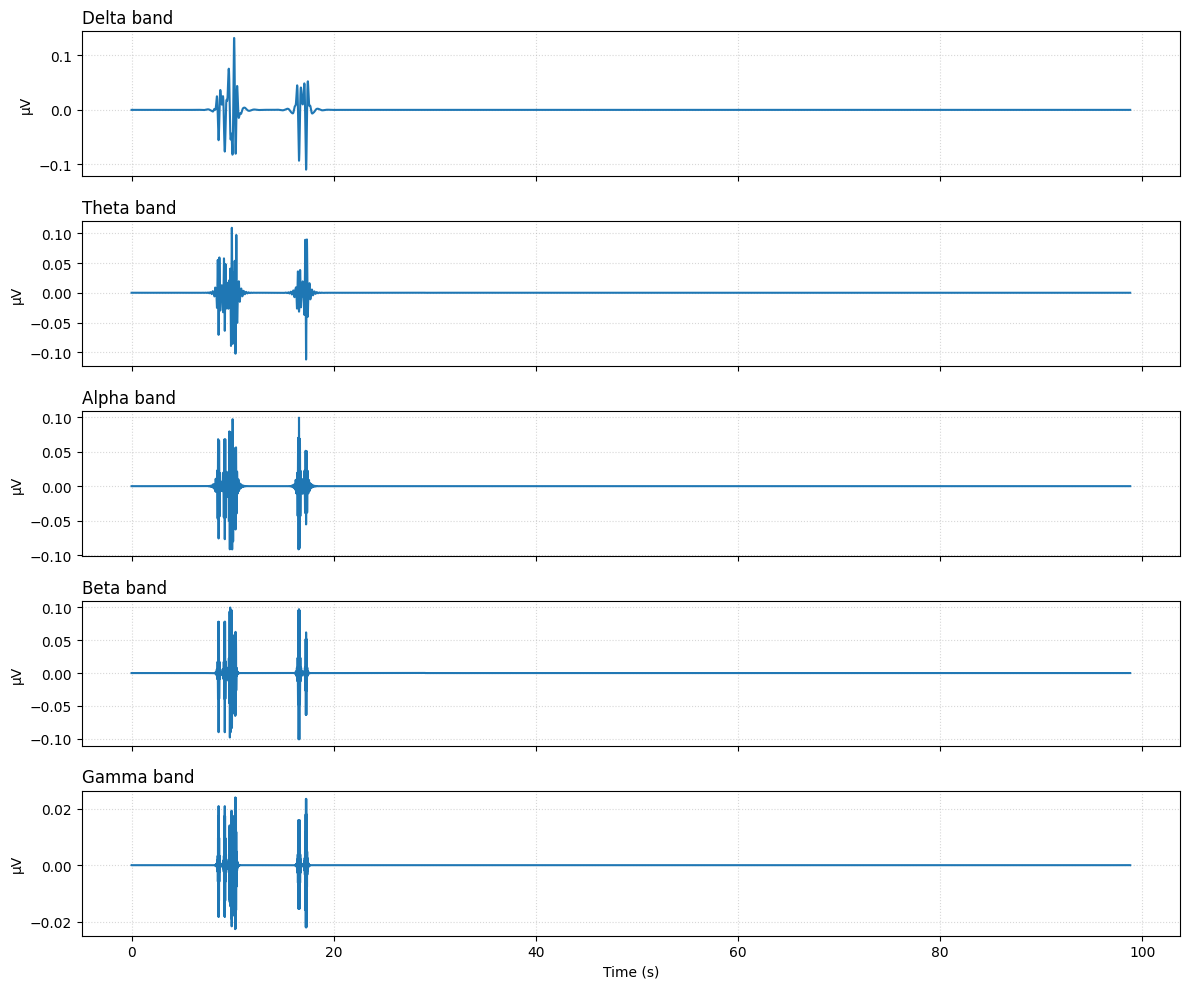

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, sosfiltfilt

# ----- Parameters -----
t = 100                   # seconds to plot
fs = 250                 # Hz (adjust to your BrainAccess device)
n_samples = int(fs * t)  # number of samples to plot
time = np.arange(n_samples) / fs

# Example EEG array (samples × channels)
# signals2 = np.random.randn(10*fs, 32) * 10   # dummy 10s × 32 channels

# Band definitions
bands = {
    "delta": (0.5, 4),
    "theta": (4, 8),
    "alpha": (8, 13),
    "beta":  (13, 30),
    "gamma": (30, 45)
}

# ----- Functions -----
def bandpass_filter(data, fs, band, order=4):
    """Apply zero-phase bandpass filter to multi-channel EEG.
    data: ndarray (samples × channels)"""
    low, high = band
    sos = butter(order, [low, high], btype="bandpass", fs=fs, output="sos")
    return sosfiltfilt(sos, data, axis=0)

# ----- Apply filters -----
filtered = {}
for name, (low, high) in bands.items():
    filtered[name] = bandpass_filter(signals2, fs, (low, high))

# ----- Plot one channel across bands -----
ch = 2  # zero-based index; channel 2 here means the 3rd column in signals2
n_bands = len(bands)
fig, axs = plt.subplots(n_bands, 1, figsize=(12, 2*n_bands), sharex=True)

for ax, (name, sig) in zip(axs, filtered.items()):
    # Ensure we don’t exceed available samples
    samples_to_plot = min(n_samples, sig.shape[0])
    ax.plot(time[:samples_to_plot], sig[:samples_to_plot, ch], color="C0")
    ax.set_title(f"{name.capitalize()} band", loc="left")
    ax.set_ylabel("µV")  # BrainAccess reports in microvolts
    ax.grid(True, linestyle=":", alpha=0.5)

axs[-1].set_xlabel("Time (s)")
plt.tight_layout()
plt.show()


In [30]:
eeg_df['time_from_onset'] = 0.0  # new column
signals2['time_from_onset'] = 0.0  # new column
for t in range(len(ann.onset) - 1):
    mask = (eeg_df['t_s'] > ann.onset[t]) & (eeg_df['t_s'] < ann.onset[t+1])
    eeg_df.loc[mask, 'time_from_onset'] = eeg_df.loc[mask, 't_s'] - ann.onset[t]
    signals2.loc[mask, 'time_from_onset'] = signals2.loc[mask, 't_s'] - ann.onset[t]

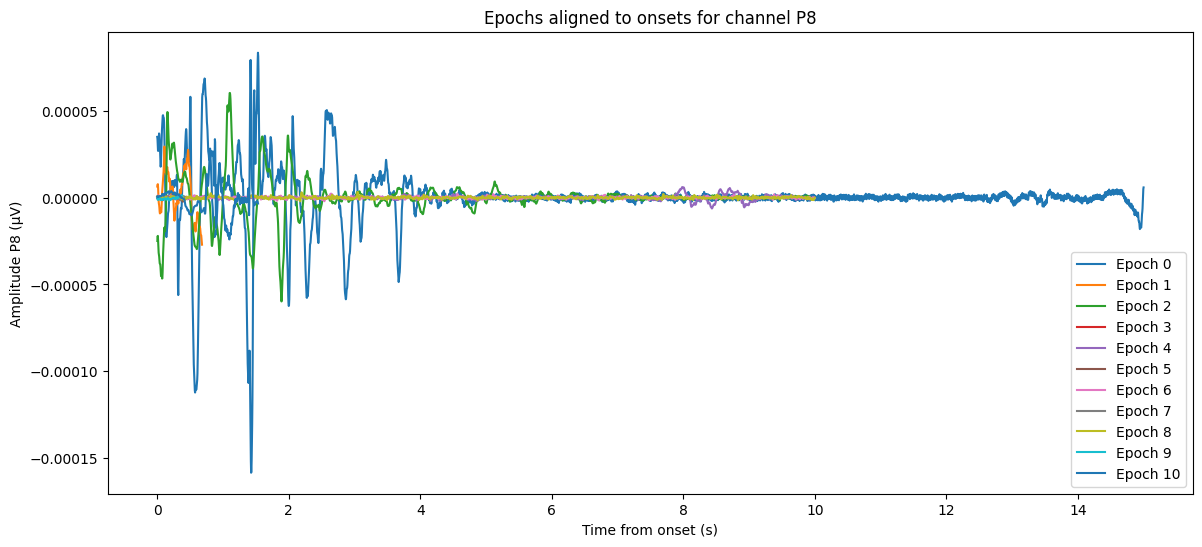

In [31]:
plt.figure(figsize=(14, 6))
ch='P8'
for t in range(len(ann.onset) - 1):
    mask = (eeg_df['t_s'] > ann.onset[t]) & (eeg_df['t_s'] < ann.onset[t+1])
    plt.plot(
        eeg_df.loc[mask, 'time_from_onset'],
        eeg_df.loc[mask, ch],
        label=f"Epoch {t}"
    )

plt.xlabel("Time from onset (s)")
plt.ylabel(f"Amplitude {ch} (µV)")
plt.title(f"Epochs aligned to onsets for channel {ch}")
plt.legend()
plt.show()


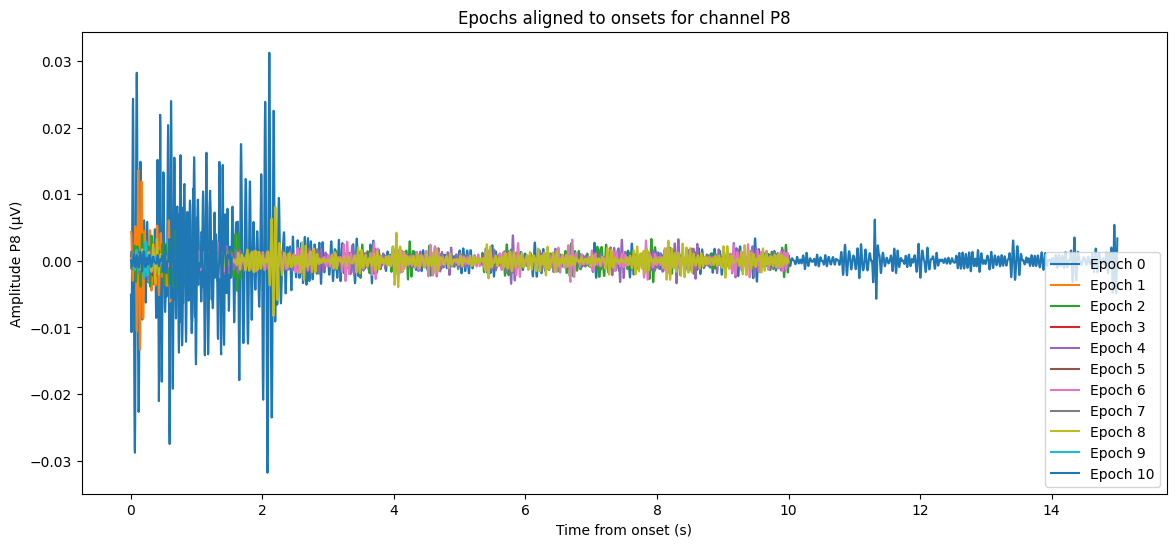

In [ ]:
plt.figure(figsize=(14, 6))
band='beta'
data_band=np.mean(pd.DataFrame(filtered[band]),1)
for t in range(len(ann.onset) - 1):
    mask = (eeg_df['t_s'] > ann.onset[t]) & (eeg_df['t_s'] < ann.onset[t+1])
    plt.plot(
        eeg_df.loc[mask, 'time_from_onset'],
        data_band[mask],
        label=f"Epoch {t}"
    )

plt.xlabel("Time from onset (s)")
plt.ylabel(f"Amplitude {ch} (µV)")
plt.title(f"Epochs aligned to onsets for power band {band}")
plt.legend()
plt.show()


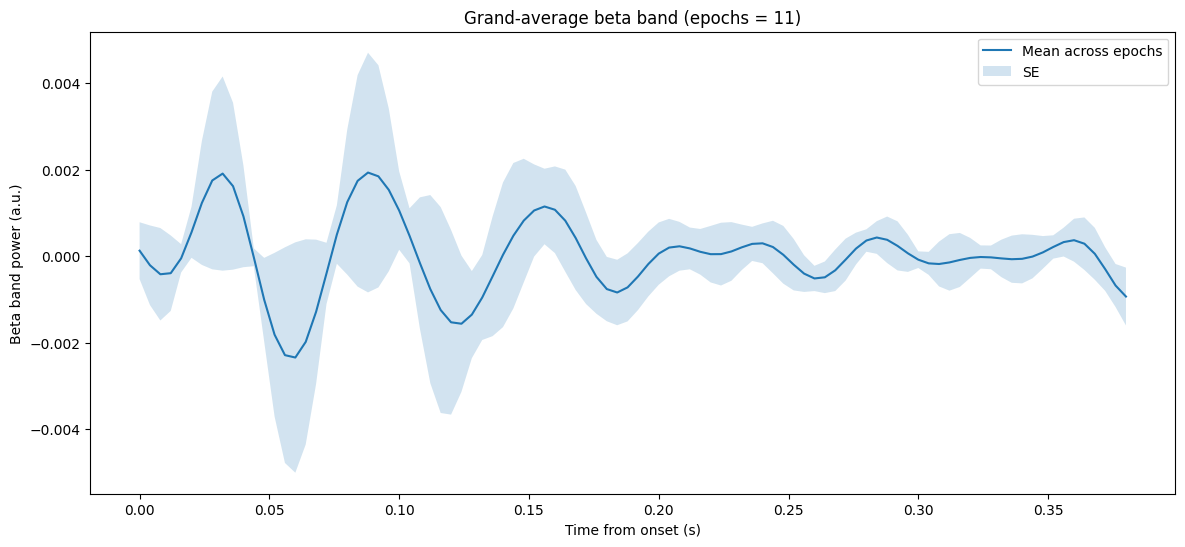

In [58]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

band = 'beta'
# If filtered[band] might be a list/array of per-channel values per sample,
# you've already averaged across channels into a 1D series:
data_band = np.mean(pd.DataFrame(filtered[band]), axis=1).to_numpy()

t_onset = np.asarray(ann.onset)
N = len(t_onset) - 1

# 1) Collect per-epoch time vectors and values
epoch_times = []
epoch_vals  = []
for t in range(N):
    mask = (eeg_df['t_s'] > t_onset[t]) & (eeg_df['t_s'] < t_onset[t+1])
    x = eeg_df.loc[mask, 'time_from_onset'].to_numpy()
    y = data_band[mask]
    # keep only finite samples
    good = np.isfinite(x) & np.isfinite(y)
    x, y = x[good], y[good]
    if x.size < 2:
        continue
    epoch_times.append(x)
    epoch_vals.append(y)

if len(epoch_times) == 0:
    raise ValueError("No valid epochs found between consecutive onsets.")

# 2) Common time grid: median dt; duration = shortest epoch
all_dts = np.concatenate([np.diff(et) for et in epoch_times if et.size > 1])
dt = float(np.median(all_dts)) if all_dts.size else float(np.median(np.diff(epoch_times[0])))
t0 = 0.0  # assuming time_from_onset starts at 0 for each epoch
t_end = float(min(et[-1] for et in epoch_times))
t_grid = np.arange(t0, t_end + 1e-12, dt)

# 3) Interpolate each epoch onto the grid
epochs = np.vstack([
    np.interp(t_grid, et, ev) for et, ev in zip(epoch_times, epoch_vals)
])  # shape: (n_epochs, n_time)

# 4) Mean and SEM across epochs
mean_sig = epochs.mean(axis=0)
std_sig  = epochs.std(axis=0, ddof=1) if epochs.shape[0] > 1 else np.zeros_like(mean_sig)
sem_sig  = std_sig / np.sqrt(epochs.shape[0]) if epochs.shape[0] > 1 else np.zeros_like(mean_sig)

# 5) Plot
plt.plot(t_grid, mean_sig, label='Mean across epochs')
if epochs.shape[0] > 1:
    plt.fill_between(t_grid, mean_sig - sem_sig, mean_sig + sem_sig, alpha=0.2, label='SE')

plt.xlabel("Time from onset (s)")
plt.ylabel(f"{band.capitalize()} band power (a.u.)")
plt.title(f"Grand-average {band} band (epochs = {epochs.shape[0]})")
plt.legend()
plt.show()


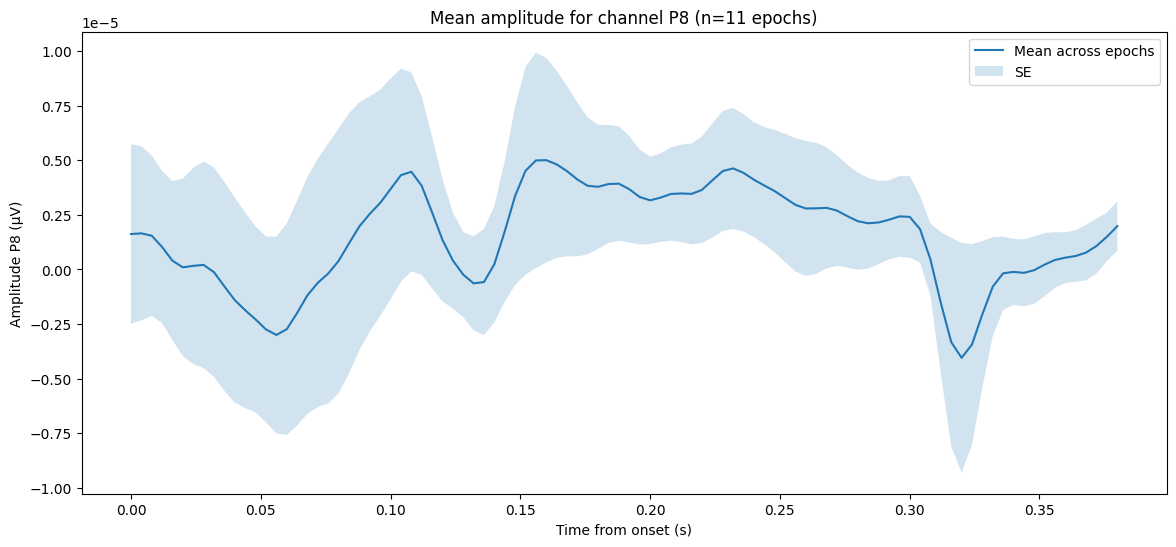

In [47]:

plt.figure(figsize=(14, 6))

ch = 'P8'
t_onset = np.asarray(ann.onset)
markers = np.asarray(ann.description)
N = len(markers) - 1

# 1) Collect per-epoch time and signal
epoch_times = []
epoch_vals = []
for t in range(N):
    mask = (signals2['t_s'] > t_onset[t]) & (signals2['t_s'] < t_onset[t+1])
    x = signals2.loc[mask, 'time_from_onset'].to_numpy()
    y = signals2.loc[mask, ch].to_numpy()
    if x.size == 0:
        continue
    epoch_times.append(x)
    epoch_vals.append(y)

if len(epoch_times) < 1:
    raise ValueError("No epochs found with the provided onsets/masks.")

# 2) Build a common time grid (step from median dt; length = shortest epoch)
dt = float(np.median(np.diff(epoch_times[0])))
t_end = float(min(et[-1] for et in epoch_times))
t_grid = np.arange(0.0, t_end + 1e-12, dt)

# 3) Interpolate each epoch to the common grid
epochs = np.vstack([
    np.interp(t_grid, et, ev) for et, ev in zip(epoch_times, epoch_vals)
])

# 4) Mean and SEM across epochs
mean_sig = epochs.mean(axis=0)
std_sig  = epochs.std(axis=0, ddof=1) if epochs.shape[0] > 1 else np.zeros_like(mean_sig)
sem_sig  = std_sig / np.sqrt(epochs.shape[0]) if epochs.shape[0] > 1 else np.zeros_like(mean_sig)

# 5) Plot
plt.plot(t_grid, mean_sig, label='Mean across epochs')
if epochs.shape[0] > 1:
    plt.fill_between(t_grid, mean_sig - sem_sig, mean_sig + sem_sig, alpha=0.2, label='SE')

plt.xlabel("Time from onset (s)")
plt.ylabel(f"Amplitude {ch} (µV)")
plt.title(f"Mean amplitude for channel {ch} (n={epochs.shape[0]} epochs)")
plt.legend()
plt.show()

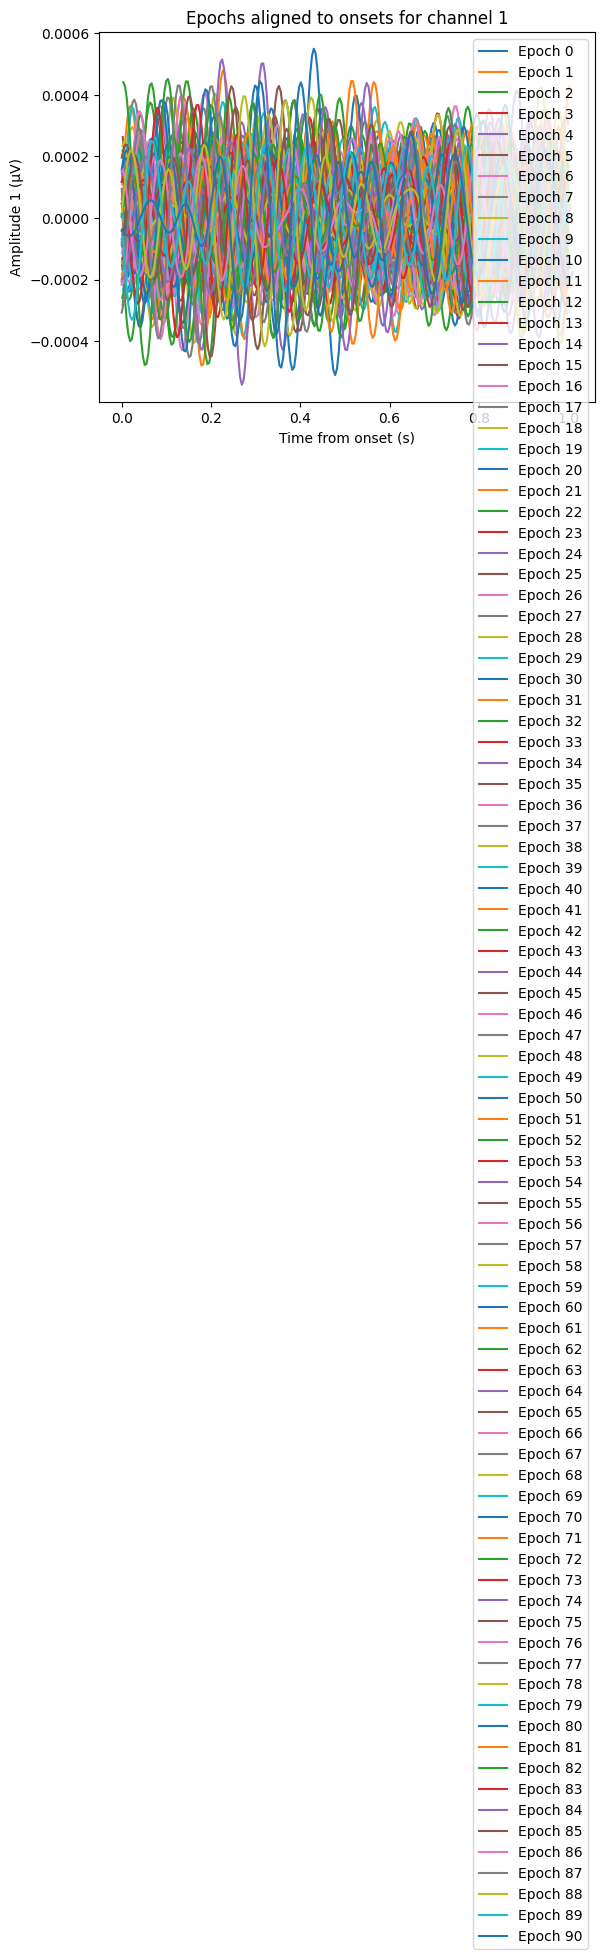

In [136]:
ch=1
band='alpha'
for t in range(len(ann.onset) - 1):
    mask = (signals2['t_s'] > ann.onset[t]) & (signals2['t_s'] < ann.onset[t+1])
    
    plt.plot(
        signals2.loc[mask, 'time_from_onset'],
        filtered[band][mask,ch],
        label=f"Epoch {t}"
    )

plt.xlabel("Time from onset (s)")
plt.ylabel(f"Amplitude {ch} (µV)")
plt.title(f"Epochs aligned to onsets for channel {ch}")
plt.legend()
plt.show()

In [ ]:
### filtered signals to dataframe and save as csv

# shape = (n_channels, n_samples)

n_channels, n_samples = signals2.shape

# Get channel names from meta
ch_names = meta['channels'][0].split(",")  # list of 38 names

# Build DataFrame → rows = samples, cols = channels
df = pd.DataFrame(signals2.T, columns=ch_names)

# Save to CSV
df.to_csv("eeg_data_with_channels.csv", index=False)


### bands to dataframe and save as csv




In [ ]:
n_channels, n_samples = filtered.shape

# Get channel names from meta
ch_names = meta['channels'][0].split(",")  # list of 38 names

# Build DataFrame → rows = samples, cols = channels
df = pd.DataFrame(signals2.T, columns=ch_names)

# Save to CSV
df.to_csv("eeg_data_with_channels.csv", index=False)

Topological plots: Topological plots - to see eeg activity by brain zone

In [ ]:
import mne

# Example: assume band_power is a dict of band → (channels,)
band_power=filtered

# Create MNE info object with channel names and montage
ch_names=meta['channels'][0][:109]
ch_names = ch_names.split(",")
sfreq = fs  # sampling freq
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types="eeg")


for band in bands.keys():
    print(band)
    # Apply a standard 10-20 electrode montage
    montage = mne.channels.make_standard_montage("standard_1020")
    info.set_montage(montage)


    # Pick alpha band data
    alpha_power_mean = np.sqrt(np.mean(band_power[band][:32, :]**2, axis=1)) # shape (32,)

    evoked = mne.EvokedArray(alpha_power_mean[:,np.newaxis], info, tmin=0)

    # Plot topomap (alpha band power distribution)
    evoked.plot_topomap(times=[0], scalings=1, time_format="", cmap="viridis",units="µV",cbar_fmt="%.1f")

In [ ]:
import time
import brainaccess_board as bb
stim = bb.stimulation_connect(name="Marker")


False

In [9]:
import time
import brainaccess_board as bb

# Create an LSL stream with markers
stim = bb.stimulation_connect(name="Marker")

# Check if there are consumers for the stream
number = 0
print("Markers will not be sent until Markers LSL stream is connected to BrainAccess Board.")
while True:
    if stim.have_consumers():
        # Send a marker
        stim.annotate(str(number))
        print(f"Sent marker: {number}")
        number += 1
        time.sleep(1)

Markers will not be sent until Markers LSL stream is connected to BrainAccess Board.
Sent marker: 0
Sent marker: 1
Sent marker: 2
Sent marker: 3
Sent marker: 4
Sent marker: 5
Sent marker: 6
Sent marker: 7
Sent marker: 8
Sent marker: 9
Sent marker: 10
Sent marker: 11
Sent marker: 12
Sent marker: 13
Sent marker: 14
Sent marker: 15
Sent marker: 16
Sent marker: 17
Sent marker: 18
Sent marker: 19
Sent marker: 20
Sent marker: 21
Sent marker: 22
Sent marker: 23
Sent marker: 24
Sent marker: 25
Sent marker: 26
Sent marker: 27
Sent marker: 28
Sent marker: 29


KeyboardInterrupt: 

In [22]:
import brainaccess_board as bb
import numpy as np
import mne

# 1) Connect to the active BrainAccess Board database
db, ok = bb.db_connect()                         # uses the “current” session by default
assert ok, "Could not connect to Board DB"

# 2) Pull MNE objects; include your marker stream by name
#    (use the same name you passed to stimulation_connect(name="Marker"))
raw_dict = db.get_mne(marker_devices_include=["Marker"])  # or leave empty to include all markers

# 3) Pick your EEG device (there’s usually just one)
raw = next(iter(raw_dict.values()))

# 4) Annotations live here:
ann = raw.annotations
print("N annotations:", len(ann))
print("First few onsets (s):", ann.onset[:5])
print("First few labels:", ann.description[:5])


Error in marker Marker 'time'
N annotations: 0
First few onsets (s): []
First few labels: []
